In [6]:
# https://pythonprogramming.net/advanced-matplotlib-graphing-charting-tutorial/

In [7]:
from pandas import DataFrame, Series
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker as mticker
from matplotlib.finance import candlestick_ohlc
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY, YEARLY
from matplotlib.dates import MonthLocator, MONTHLY
import datetime as dt
import pylab

MA1 = 10
MA2 = 50
startdate = dt.date(2016, 6, 29)


def rsiFunc(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n + 1]
    up = seed[seed >= 0].sum() / n
    down = -seed[seed < 0].sum() / n
    rs = up / down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100. / (1. + rs)

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # cause the diff is 1 shorter

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up * (n - 1) + upval) / n
        down = (down * (n - 1) + downval) / n

        rs = up / down
        rsi[i] = 100. - 100. / (1. + rs)

    return rsi


def ExpMovingAverage(values, window):
    weights = np.exp(np.linspace(-1., 0., window))
    weights /= weights.sum()
    a = np.convolve(values, weights, mode='full')[:len(values)]
    a[:window] = a[window]
    return a


def computeMACD(x, slow=26, fast=12):
    """
    compute the MACD (Moving Average Convergence/Divergence) using a fast and slow exponential moving avg'
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = ExpMovingAverage(x, slow)
    emafast = ExpMovingAverage(x, fast)
    return emaslow, emafast, emafast - emaslow


def generateDate():
    init_close_price = 100
    days = 200
    startdate = dt.date(2016, 6, 29)
    df = pd.DataFrame(0.0, index=np.arange(days), columns=[
                      'Open', 'High', 'Close', 'Low', 'Volume'])
    df.index = pd.date_range(startdate, periods=df.shape[0])
    df.index.name = 'DateTime'

    for i in range(days):
        if i == 0:
            yesterday_close = init_close_price
        else:
            yesterday_close = df.loc[df.index[[i - 1]], 'Close'].item()
        down_rate, up_rate = np.sort(np.random.rand(2) / 5 - 0.1)
        high = yesterday_close * (1 + up_rate)
        low = yesterday_close * (1 + down_rate)

        price_range = high - low
        open_price, close_price = low + price_range * np.random.rand(2)
        volume = 20 + np.random.randint(20)
        df.iloc[i] = open_price, high, close_price, low, volume
    #     print(   open_price, close_price    , price_range, yesterday_close,type(yesterday_close))
    #     pass
    return df

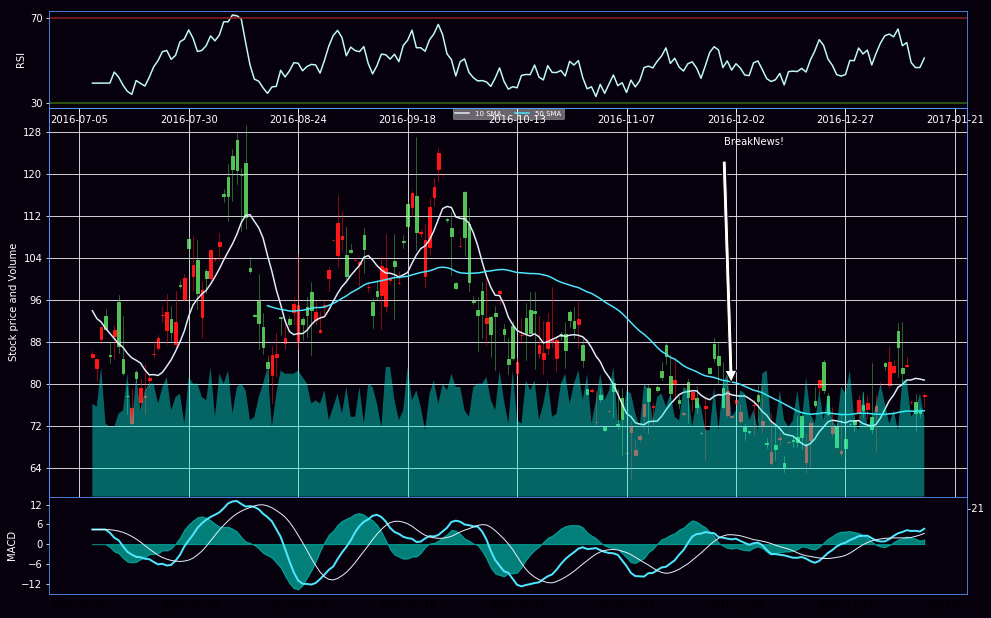

In [8]:

def main():
    days = generateDate()
#     print(days.head())
    daysreshape = days.reset_index()
    daysreshape['DateTime'] = mdates.date2num(daysreshape['DateTime'].astype(dt.date))
    daysreshape.drop('Volume', axis=1, inplace=True)
    daysreshape = daysreshape.reindex(columns=['DateTime', 'Open', 'High', 'Low', 'Close'])

    Av1 = daysreshape.Close.rolling(window=MA1).mean()
    Av2 = daysreshape.Close.rolling(window=MA2).mean()

    # 有效天数 SP = days - max(MA1, MA2) + 1
    SP = len(daysreshape.DateTime.values[MA1 - 1:])

    fig = plt.figure(facecolor='#07000d', figsize=(15, 10))

    ax1 = plt.subplot2grid((6, 4), (1, 0), rowspan=4, colspan=4, facecolor='#07000d')
    candlestick_ohlc(ax1, daysreshape.values[-SP:], width=.6,
                     colorup='#ff1717', colordown='#53c156')
    Label1 = str(MA1) + ' SMA'
    Label2 = str(MA2) + ' SMA'
    ax1.grid(True, color='w')
    # MA10
    ax1.plot(daysreshape.DateTime.values[-SP:], Av1[-SP:], '#e1edf9', label=Label1, linewidth=1.5)
    # MA50
    ax1.plot(daysreshape.DateTime.values[-SP:], Av2[-SP:], '#4ee6fd', label=Label2, linewidth=1.5)

    ax1.spines['bottom'].set_color("#5998ff")
    ax1.spines['top'].set_color("#5998ff")
    ax1.spines['left'].set_color("#5998ff")
    ax1.spines['right'].set_color("#5998ff")

    ax1.yaxis.label.set_color("w")
    ax1.tick_params(axis='y', colors='w')
    plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(prune='upper'))
    plt.ylabel('Stock price and Volume')

    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.tick_params(axis='x', colors='w')

    maLeg = plt.legend(loc=9, ncol=2, prop={'size': 7},
                       fancybox=True, borderaxespad=0.)

    maLeg.get_frame().set_alpha(0.4)
    textEd = pylab.gca().get_legend().get_texts()
    pylab.setp(textEd[0:5], color='w')

    ax0 = plt.subplot2grid((6, 4), (0, 0), sharex=ax1, rowspan=1, colspan=4, facecolor='#07000d')
    rsi = rsiFunc(daysreshape.Close.values)
    rsiCol = '#c1f9f7'
    posCol = '#386d13'
    negCol = '#8f2020'

    ax0.plot(daysreshape.DateTime.values[-SP:], rsi[-SP:], rsiCol, linewidth=1.5)
    ax0.axhline(70, color=negCol)
    ax0.axhline(30, color=posCol)

    ax0.fill_between(daysreshape.DateTime.values[-SP:], rsi[-SP:], 70,
                     where=(rsi[-SP:] >= 70), facecolor=negCol, edgecolor=negCol, alpha=0.5)
    ax0.fill_between(daysreshape.DateTime.values[-SP:], rsi[-SP:], 30,
                     where=(rsi[-SP:] <= 30), facecolor=posCol, edgecolor=posCol, alpha=0.5)
    ax0.set_yticks([30, 70])
    ax0.yaxis.label.set_color("w")
    ax0.spines['bottom'].set_color("#5998ff")
    ax0.spines['top']   .set_color("#5998ff")
    ax0.spines['left'].set_color("#5998ff")
    ax0.spines['right'].set_color("#5998ff")
    ax0.tick_params(axis='y', colors='w')
    ax0.tick_params(axis='x', colors='w')
    plt.ylabel('RSI')

    volumeMin = 0
    ax1v = ax1.twinx()
    ax1v.fill_between(daysreshape.DateTime.values[-SP:], volumeMin,
                      days.Volume.values[-SP:], facecolor='#00ffe8', alpha=.4)
    ax1v.axes.yaxis.set_ticklabels([])
    ax1v.grid(False)
    # Edit this to 3, so it's a bit larger
    ax1v.set_ylim(0, 3 * days.Volume.values.max())
    ax1v.spines['bottom'].set_color("#5998ff")
    ax1v.spines['top'].set_color("#5998ff")
    ax1v.spines['left'].set_color("#5998ff")
    ax1v.spines['right'].set_color("#5998ff")
    # ax1v.tick_params(axis='x', colors='w')
    # ax1v.tick_params(axis='y', colors='w')
 # plot an MACD indicator on bottom
    ax2 = plt.subplot2grid((6, 4), (5, 0), sharex=ax1, rowspan=1, colspan=4, facecolor='#07000d')
    fillcolor = '#00ffe8'
    nslow = 26
    nfast = 12
    nema = 9
    emaslow, emafast, macd = computeMACD(daysreshape.Close.values)
    ema9 = ExpMovingAverage(macd, nema)
    ax2.plot(daysreshape.DateTime.values[-SP:], macd[-SP:], color='#4ee6fd', lw=2)
    ax2.plot(daysreshape.DateTime.values[-SP:], ema9[-SP:], color='#e1edf9', lw=1)
    ax2.fill_between(daysreshape.DateTime.values[-SP:], macd[-SP:] -
                     ema9[-SP:], 0, alpha=0.5, facecolor=fillcolor, edgecolor=fillcolor)
    plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(prune='upper'))
    ax2.spines['bottom'].set_color("#5998ff")
    ax2.spines['top'].set_color("#5998ff")
    ax2.spines['left'].set_color("#5998ff")
    ax2.spines['right'].set_color("#5998ff")
    # ax2.tick_params(axis='x', colors='w')
    ax2.tick_params(axis='y', colors='w')
    plt.ylabel('MACD', color='w')
    ax2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5, prune='upper'))
    # for label in ax2.xaxis.get_ticklabels():
    #     label.set_rotation(45)

    # plt.setp(ax0.get_xticklabels(), visible=False)
    # plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.annotate('BreakNews!', (daysreshape.DateTime.values[155], Av1[155]),
                 xytext=(0.8, 0.9), textcoords='axes fraction',
                 arrowprops=dict(facecolor='white', shrink=0.05),
                 fontsize=10, color='w',
                 horizontalalignment='right', verticalalignment='bottom')

    plt.subplots_adjust(left=.09, bottom=.14, right=.94, top=.95, wspace=.20, hspace=0)

    plt.show()


if __name__ == "__main__":
    main()